In [5]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets download -d shravankumar9892/image-colorization

100% 2.10G/2.10G [00:23<00:00, 115MB/s]
100% 2.10G/2.10G [00:23<00:00, 96.8MB/s]


In [9]:
! unzip image-colorization.zip

Archive:  image-colorization.zip
  inflating: ab/ab/ab1.npy           
  inflating: ab/ab/ab2.npy           
  inflating: ab/ab/ab3.npy           
  inflating: inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5  
  inflating: l/gray_scale.npy        


In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
./image-colorization.zip
./kaggle.json
./.config/.last_survey_prompt.yaml
./.config/active_config
./.config/.last_opt_in_prompt.yaml
./.config/gce
./.config/.last_update_check.json
./.config/config_sentinel
./.config/configurations/config_default
./.config/logs/2022.02.01/14.30.57.022317.log
./.config/logs/2022.02.01/14.31.58.218326.log
./.config/logs/2022.02.01/14.31.57.576848.log
./.config/logs/2022.02.01/14.31.16.993813.log
./.config/logs/2022.02.01/14.31.33.364834.log
./.config/logs/2022.02.01/14.31.40.709264.log
./ab/ab/ab1.npy
./ab/ab/ab3.npy
./ab/ab/ab2.npy
./l/gray_scale.npy
./sample_data/anscombe.json
./sample_data/README.md
./sample_data/mnist_test.csv
./sample_data/mnist_train_small.csv
./sample_data/california_housing_train.csv
./sample_data/california_housing_test.csv


In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,InputLayer, Conv2DTranspose, Dropout, BatchNormalization, Input, Concatenate, Activation, concatenate ,RepeatVector ,Reshape ,UpSampling2D
from keras.initializers import RandomNormal
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import cv2
import PIL
from skimage import transform
from PIL import Image
import random
import h5py
import os
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [12]:
images_gray = np.load("./l/gray_scale.npy")
images_ab1 = np.load("./ab/ab/ab1.npy")
images_ab2 = np.load("./ab/ab/ab2.npy")
images_ab3 = np.load("./ab/ab/ab3.npy")

In [13]:
#taking training data of 100
X_train = (images_gray[:200,:,:].astype('float')).reshape(200,224,224,1) #reshaping the input gray images
Y = (images_ab1[:200,:,:].astype('float'))
X_test = (images_gray[300:500,:,:].astype('float')).reshape(200,224,224,1)
Y_test = (images_ab1[300:500,:,:].astype('float'))

In [14]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input
inception = InceptionResNetV2(weights=None, include_top=True)
inception.load_weights('./inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5')
inception.graph = tf.get_default_graph()

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Colocations handled automatically by placer.


In [15]:
#To generate embeddings of 1000*1 by passing input images through InceptionResNetV2
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb_resized)
    return embed
import tensorflow as tf

In [16]:
#creating embeddings for Train data
incept_em = create_inception_embedding(X_train)
embeddings = RepeatVector(28 * 28)(incept_em)
layer_embedding_train = Reshape(([28, 28, 1000]))(embeddings)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [17]:
print(layer_embedding_train.shape)

(200, 28, 28, 1000)


In [18]:
model_path = "./color_model.h5"
checkpoint = ModelCheckpoint(model_path,
                            monitor = "val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose = 1)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [19]:
#Encoder
embed_input = Input(shape=(28, 28, 1000))
encoder_input = Input(shape=(224, 224, 1,))
encoder_1 = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_2 = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_1)
encoder_3 = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_2)
encoder_4 = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_3)
encoder_5 = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_4)
encoder_6 = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_5)
encoder_7 = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_6)
encoder_output= Conv2D(256, (3,3), activation='relu', padding='same')(encoder_7)
#Fusion layer
fusion_output = concatenate([encoder_output, embed_input], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output)
#Decoder layer
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
model = Model(inputs=[encoder_input,embed_input], outputs=decoder_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 112, 112, 64  640         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_204 (Conv2D)            (None, 112, 112, 12  73856       ['conv2d_203[0][0]']             
                                8)                                                            

In [20]:
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
history = model.fit(x=[X_train,layer_embedding_train] ,y=Y,callbacks = [checkpoint,es], batch_size=10, epochs=2500,steps_per_epoch=1)

Streaming output truncated to the last 5000 lines.
Epoch 1251/2500
1/1 [==============================] - 4s 4s/step - batch: 0.0000e+00 - size: 1.0000 - loss: 183.0659 - acc: 0.5079
Epoch 1252/2500
1/1 [==============================] - 4s 4s/step - batch: 0.0000e+00 - size: 1.0000 - loss: 183.6889 - acc: 0.5075
Epoch 1253/2500
1/1 [==============================] - 4s 4s/step - batch: 0.0000e+00 - size: 1.0000 - loss: 184.3366 - acc: 0.5080
Epoch 1254/2500
1/1 [==============================] - 4s 4s/step - batch: 0.0000e+00 - size: 1.0000 - loss: 185.1053 - acc: 0.5075
Epoch 1255/2500
1/1 [==============================] - 4s 4s/step - batch: 0.0000e+00 - size: 1.0000 - loss: 185.3069 - acc: 0.5081
Epoch 1256/2500
1/1 [==============================] - 4s 4s/step - batch: 0.0000e+00 - size: 1.0000 - loss: 185.3310 - acc: 0.5075
Epoch 1257/2500
1/1 [==============================] - 4s 4s/step - batch: 0.0000e+00 - size: 1.0000 - loss: 184.4009 - acc: 0.5082
Epoch 1258/2500
1/1 [====

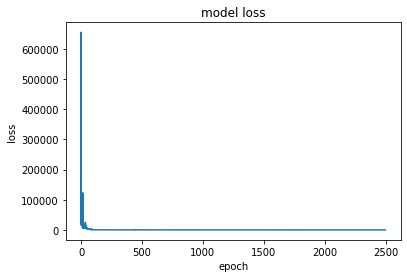

In [21]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

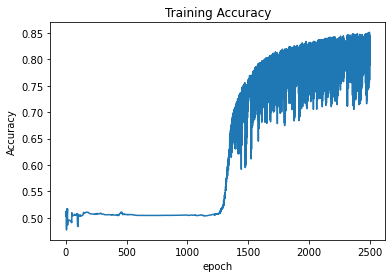

In [22]:
plt.plot(history.history['acc'])
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.show()

In [23]:
# creating embeddings for test data
incept_em = create_inception_embedding(X_test)
embeddings = RepeatVector(28 * 28)(incept_em)
layer_embedding_test = Reshape(([28, 28, 1000]))(embeddings)

In [24]:
loss, acc = model.evaluate([X_test,layer_embedding_test] ,Y_test,steps=3)
print()
print("Test accuracy = ", acc)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Test accuracy =  0.55165


In [25]:
output = model.predict([X_test,layer_embedding_test],steps=3)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [26]:
def get_LAB(image_l, image_ab  ):
       
    image_l = image_l.reshape((224, 224, 1))
    image_lab = np.concatenate((image_l, image_ab), axis=2)
    image_lab = image_lab.astype("uint8")
 
    image_rgb = cv2.cvtColor(image_lab, cv2.COLOR_LAB2RGB)
    image_rgb = Image.fromarray(image_rgb)
    return image_rgb
def get_LAB1(image_l  ):
    image_ab =  np.ones((224,224,2))*128
    image_l = image_l.reshape((224, 224, 1))
    image_lab = np.concatenate((image_l, image_ab), axis=2)
    image_lab = image_lab.astype("uint8")
 
    image_rgb = cv2.cvtColor(image_lab, cv2.COLOR_LAB2RGB)
    image_rgb = Image.fromarray(image_rgb)
    return image_rgb

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


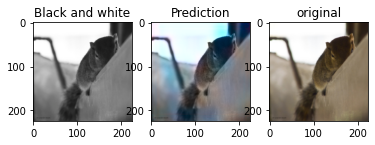

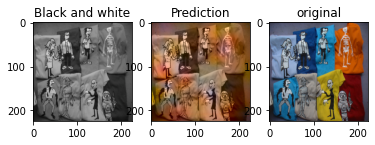

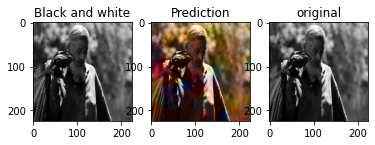

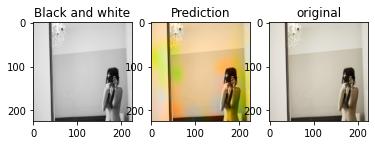

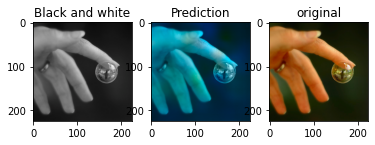

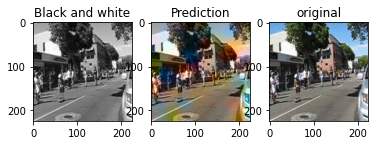

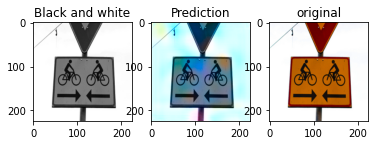

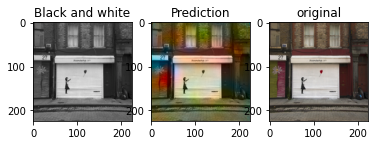

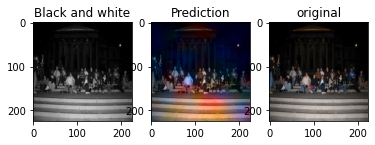

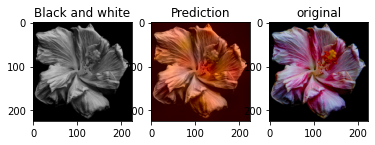

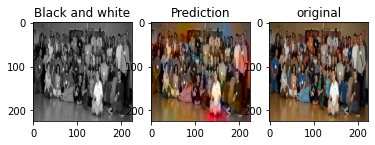

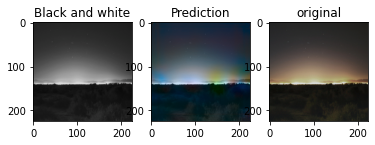

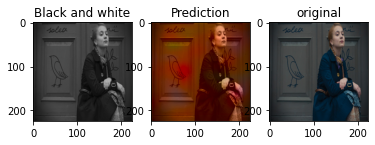

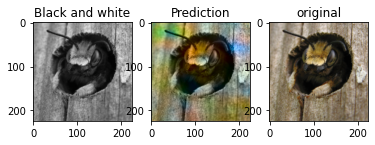

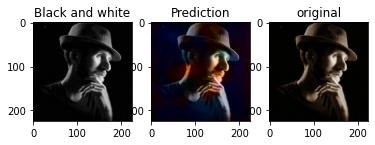

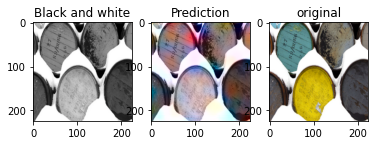

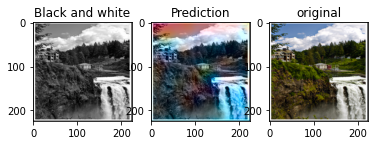

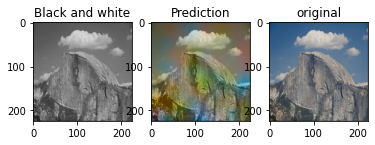

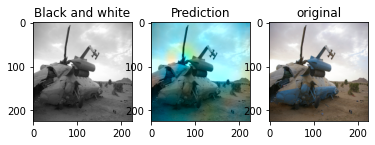

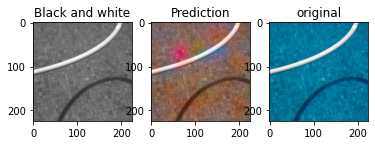

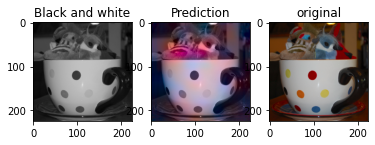

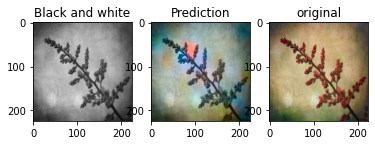

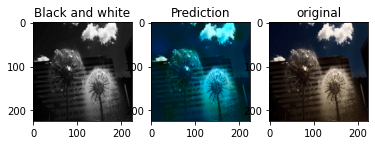

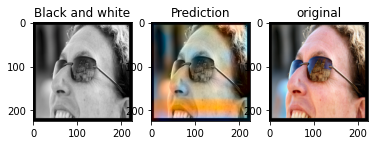

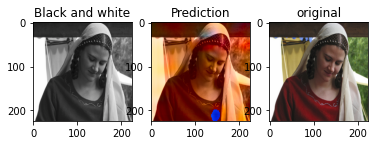

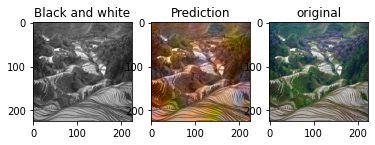

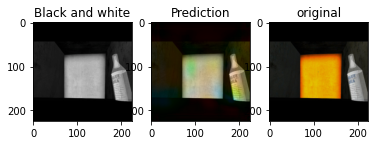

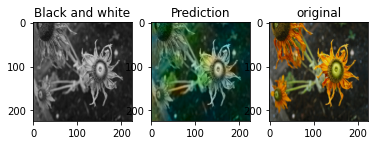

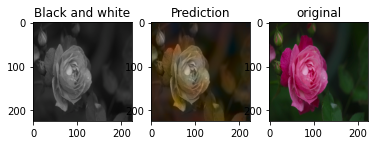

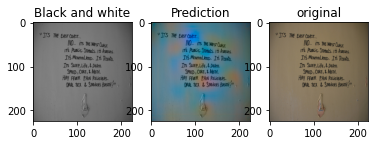

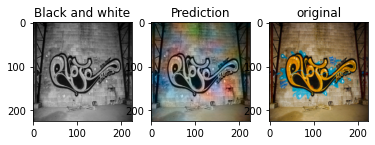

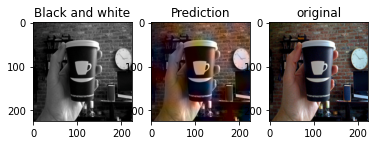

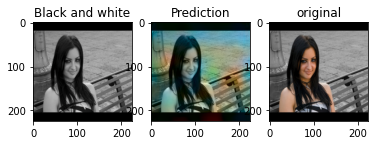

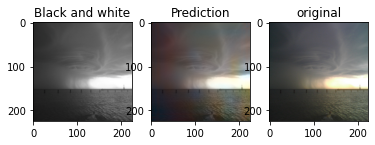

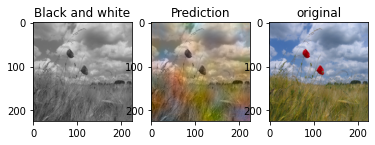

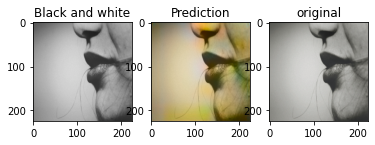

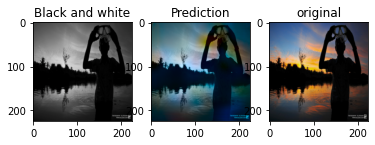

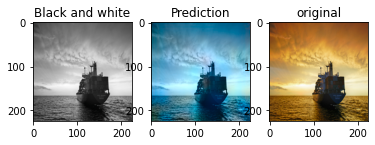

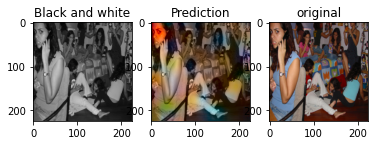

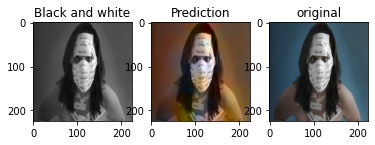

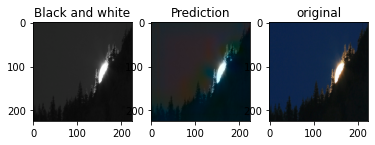

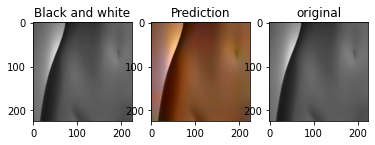

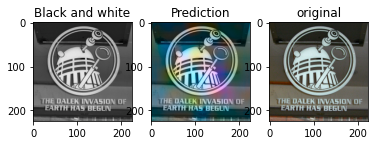

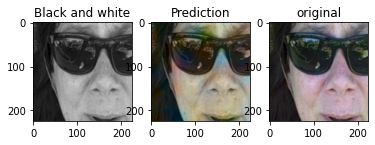

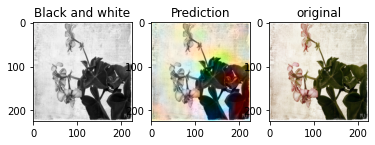

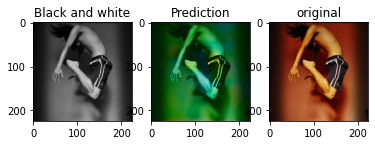

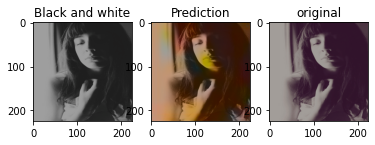

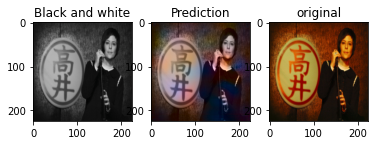

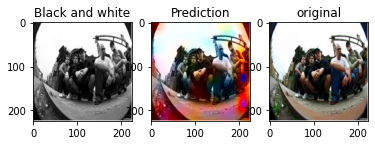

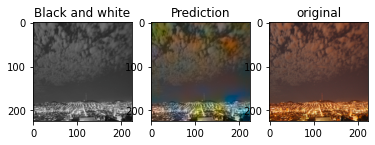

In [27]:
for i in range(50,100):
    pred = get_LAB(X_test[i],output[i])
    real = get_LAB(X_test[i],Y_test[i])
    original = get_LAB1(X_test[i])
    f, axarr = plt.subplots(1,3)
    axarr[0].title.set_text('Black and white')  
    axarr[1].title.set_text('Prediction')  
    axarr[2].title.set_text('original')  
    axarr[0].imshow(original)
    axarr[1].imshow(pred)
    axarr[2].imshow(real)